# Data generation for multiple receptor/ligand model

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import copy


# Global model variables and functions

D_ACT     = 10             # number of activating ligands
D_INH     = 22             # number of inhibitory ligands
D         = D_ACT + D_INH  # total number of ligands
INT_SIGNS = np.array([1 if i<D_ACT else -1 for i in range(D)])  # sign of interactions

L_EXP = [3, 3, 3]  # ligand expression mean values
#L_EXP = [3, 2, 1]  # ligand expression mean values (thresholded)
L_STD = [1, 1, 1]  # ligand expression standard deviations

N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

ALPHA   = 20       # immune cell effective memory length
KAPPA   = 2*ALPHA  # immune cell effective memory length
N_STEPS = 200      # number of training steps on healthy cells
THETA   = 0.01     # activation threshold

P_SCALES = [1, 3, 5, 7, 9]  # scale of perturbations

def GET_THRESHOLD(m, b):
    return sp.stats.t.ppf(1-THETA, 2*ALPHA, m, np.sqrt((KAPPA+1)*b/(KAPPA*ALPHA)))

def GET_SIGNAL(receptors, ligands, threshold=False):
    temp_ligands = np.copy(ligands)
    if threshold:
        temp_ligands[temp_ligands<0] = 0
    return np.dot(receptors, INT_SIGNS*temp_ligands)

def UPDATE_PARAMETERS(m, b, x):
    m_new = (x + (KAPPA * m))/(KAPPA + 1)
    b_new = ((ALPHA - 1)/(ALPHA - 0.5)) * (b + (KAPPA/(KAPPA+1))*(x - m)**2/2)
    return m_new, b_new


# Global data variables

DATA_FOLDER = 'data/'            # normal
#DATA_FOLDER = 'data-threshold/'  # thresholded

# Random ligand expression

### High/medium/low expression levels with dense perturbations, uncorrelated expression

In [2]:
# Generate data

data = np.zeros((N_SAMPLES, D))
for i in range(N_SAMPLES):
    for j in range(D):
        data[i][j] = np.random.normal(loc=L_EXP[j%len(L_EXP)], scale=L_STD[j%len(L_EXP)])
#         if data[i][j]<0:  # thresholded
#             data[i][j]=0
            
np.save('%s/ligand_expression.npy' % DATA_FOLDER, data)

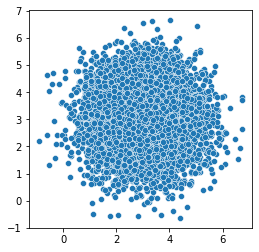

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

sns.scatterplot(x=data.T[0], y=data.T[1]);

In [4]:
def get_profile(binom=True, continuous=True):
    
    # receptor expression probability
    p_exp = BINOM_P
    if not binom:
        p_exp = 0.8
        #p_exp = 0.5  # thresholded
    
    # get profile
    temp_profile = np.zeros(D)
    
    if continuous:
        for j in range(D):
            if np.random.rand()<p_exp:
                temp_val = np.random.normal(loc=1, scale=0.2)
                while temp_val<=0:
                    temp_val = np.random.normal(loc=1, scale=0.2)
                temp_profile[j] = temp_val
                
    else:
        for j in range(D):
            if np.random.rand()<p_exp:
                temp_profile[j] = 1
                
    return temp_profile


def fill_profiles(binom=True, continuous=True):
    profiles = []
    for i in range(N_CELLS):
        temp = get_profile(binom=binom, continuous=continuous)
        while np.sum(temp)==0:
            temp = get_profile(binom=binom, continuous=continuous)
        profiles.append(temp)
    
    return np.array(profiles)


# binomial profiles

## continuous
np.save('%s/binom_profiles_continuous.npy' % DATA_FOLDER, fill_profiles(binom=True, continuous=True))

## binary
np.save('%s/binom_profiles_binary.npy' % DATA_FOLDER, fill_profiles(binom=True, continuous=False))


# uniform profiles

## continuous 
np.save('%s/uniform_profiles_continuous.npy' % DATA_FOLDER, fill_profiles(binom=False, continuous=True))
                
## binary
np.save('%s/uniform_profiles_binary.npy' % DATA_FOLDER, fill_profiles(binom=False, continuous=False))

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


distribution	mean	median	max
binomial	7.06	6.96	15.97
uniform		25.61	25.64	34.34


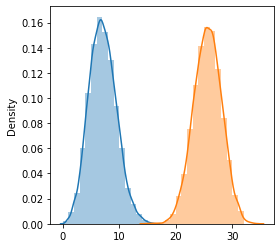

In [5]:
# number of receptors expressed

binom_profiles   = np.load('%s/binom_profiles_continuous.npy' % DATA_FOLDER)
uniform_profiles = np.load('%s/uniform_profiles_continuous.npy' % DATA_FOLDER)

binom_n   = [np.sum(p) for p in binom_profiles]
uniform_n = [np.sum(p) for p in uniform_profiles]

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

sns.distplot(binom_n, label='binomial', bins=np.arange(0, D+1));
sns.distplot(uniform_n, label='uniform', bins=np.arange(0, D+1));

print('distribution\tmean\tmedian\tmax')
print('binomial\t%.2f\t%.2f\t%.2f' % (np.mean(binom_n), np.median(binom_n), np.max(binom_n)))
print('uniform\t\t%.2f\t%.2f\t%.2f' % (np.mean(uniform_n), np.median(uniform_n), np.max(uniform_n)))

In [6]:
# cell training parameters and initialization

binom_ms = np.zeros(N_CELLS)
binom_bs = np.ones(N_CELLS)

uniform_ms = np.zeros(N_CELLS)
uniform_bs = np.ones(N_CELLS)


# training

for f in ['binom_profiles_binary', 'binom_profiles_continuous', 
          'uniform_profiles_binary', 'uniform_profiles_continuous']:
    
    profiles = np.load('%s/%s.npy' % (DATA_FOLDER, f))
    ms = np.zeros(N_CELLS)
    bs = np.ones(N_CELLS)
    
    for i in range(N_CELLS):
        for j in range(N_STEPS):
            target = data[np.random.choice(N_SAMPLES)]
            ms[i], bs[i] = UPDATE_PARAMETERS(ms[i], bs[i], GET_SIGNAL(profiles[i], target))
        
    np.savez('%s/%s_trained' % (DATA_FOLDER, f), ms=ms, bs=bs)

In [7]:
# Generate perturbations

# Dense, purely activating

perturb = np.random.normal(loc=0, scale=1, size=(N_SAMPLES, D))

for i in range(N_SAMPLES):
    perturb[i] /= np.sqrt(np.sum(perturb[i]**2))
    for j in range(D_ACT):
        if perturb[i][j]<0:
            perturb[i][j] *= -1
    for j in range(D_ACT, D):
        if perturb[i][j]>0:
            perturb[i][j] *= -1
            
perturb_dense_pure = copy.deepcopy(perturb)
np.save('%s/perturb_dense_pure.npy' % DATA_FOLDER, perturb_dense_pure)


# Dense, partially activating and partially inhibitory

for i in range(N_SAMPLES):
    subspace = np.random.choice(D, D//2, replace=False)
    norm1 = np.sqrt(np.sum([perturb[i][j]**2 for j in range(D) if j in subspace]))
    norm2 = np.sqrt(np.sum([perturb[i][j]**2 for j in range(D) if j not in subspace]))
    
    for j in range(D_ACT):
        if j in subspace:
            perturb[i][j] /= norm1
            if perturb[i][j]<0:
                perturb[i][j] *= -1
        else:
            perturb[i][j] /= norm2
            if perturb[i][j]>0:
                perturb[i][j] *= -1
    for j in range(D_ACT, D):
        if j in subspace:
            perturb[i][j] /= norm1
            if perturb[i][j]>0:
                perturb[i][j] *= -1
        else:
            perturb[i][j] /= norm2
            if perturb[i][j]<0:
                perturb[i][j] *= -1
                            
perturb_dense_hidden = copy.deepcopy(perturb)
np.save('%s/perturb_dense_hidden.npy' % DATA_FOLDER, perturb_dense_hidden)


# Sparse, purely activating

for i in range(N_SAMPLES):
    idx = np.random.choice(D)
    for j in range(D):
        if j==idx:
            if j<D_ACT:
                perturb[i][j] = 1
            else:
                perturb[i][j] = -1
        else:
            perturb[i][j] = 0

perturb_sparse_pure = copy.deepcopy(perturb)
np.save('%s/perturb_sparse_pure.npy' % DATA_FOLDER, perturb_sparse_pure)


# Sparse, partially activating and partially inhibitory

for i in range(N_SAMPLES):
    idx  = np.random.choice(D, 2, replace=False)
    idx1 = idx[0]
    idx2 = idx[1]
    for j in range(D):
        if j==idx1:
            if j<D_ACT:
                perturb[i][j] = 1
            else:
                perturb[i][j] = -1
        elif j==idx2:
            if j<D_ACT:
                perturb[i][j] = -1
            else:
                perturb[i][j] = 1
        else:
            perturb[i][j] = 0

perturb_sparse_hidden = copy.deepcopy(perturb)
np.save('%s/perturb_sparse_hidden.npy' % DATA_FOLDER, perturb_sparse_hidden)

In [8]:
# activation against perturbations

data = np.load('%s/ligand_expression.npy' % DATA_FOLDER)

for sparsity in ['sparse', 'dense']:
    for ptype in ['pure', 'hidden']:
        for scale in P_SCALES:
            perturb  = np.load('%s/perturb_%s_%s.npy' % (DATA_FOLDER, sparsity, ptype))
            perturb *= scale

            for prof in ['binary', 'continuous']:
                binom_profiles   = np.load('%s/binom_profiles_%s.npy'   % (DATA_FOLDER, prof))
                uniform_profiles = np.load('%s/uniform_profiles_%s.npy' % (DATA_FOLDER, prof))

                binom_mbs = np.load('%s/binom_profiles_%s_trained.npz' % (DATA_FOLDER, prof))
                binom_ms  = binom_mbs['ms']
                binom_bs  = binom_mbs['bs']

                uniform_mbs = np.load('%s/uniform_profiles_%s_trained.npz' % (DATA_FOLDER, prof))
                uniform_ms  = uniform_mbs['ms']
                uniform_bs  = uniform_mbs['bs']

                # unique perturbations

                binom_act   = np.zeros((N_CELLS, N_SAMPLES))
                uniform_act = np.zeros((N_CELLS, N_SAMPLES))

                for i in range(N_CELLS):
                    binom_t   = GET_THRESHOLD(binom_ms[i], binom_bs[i])
                    uniform_t = GET_THRESHOLD(uniform_ms[i], uniform_bs[i])
                    for j in range(N_SAMPLES):
                        if GET_SIGNAL(binom_profiles[i], data[j]+perturb[j]) > binom_t:
                            binom_act[i][j] = 1
                        if GET_SIGNAL(uniform_profiles[i], data[j]+perturb[j]) > uniform_t:
                            uniform_act[i][j] = 1

                np.savez_compressed('%s/response_%s_%s_%s_%d' % 
                                    (DATA_FOLDER, prof, sparsity, ptype, scale), 
                                    binom=binom_act, uniform=uniform_act)

                # all same perturbation, different targets

                binom_act   = np.zeros((N_CELLS, N_SAMPLES))
                uniform_act = np.zeros((N_CELLS, N_SAMPLES))
                idx         = 0

                for i in range(N_CELLS):
                    binom_t   = GET_THRESHOLD(binom_ms[i], binom_bs[i])
                    uniform_t = GET_THRESHOLD(uniform_ms[i], uniform_bs[i])
                    for j in range(N_SAMPLES):
                        if GET_SIGNAL(binom_profiles[i], data[j]+perturb[idx]) > binom_t:
                            binom_act[i][j] = 1
                        if GET_SIGNAL(uniform_profiles[i], data[j]+perturb[idx]) > uniform_t:
                            uniform_act[i][j] = 1

                np.savez_compressed('%s/response_%s_%s_%s_%d_perturb_%d' % 
                                    (DATA_FOLDER, prof, sparsity, ptype, scale, idx), 
                                    binom=binom_act, uniform=uniform_act)
                
                # all same target, different perturbations

                binom_act   = np.zeros((N_CELLS, N_SAMPLES))
                uniform_act = np.zeros((N_CELLS, N_SAMPLES))
                idx         = 0

                for i in range(N_CELLS):
                    binom_t   = GET_THRESHOLD(binom_ms[i], binom_bs[i])
                    uniform_t = GET_THRESHOLD(uniform_ms[i], uniform_bs[i])
                    for j in range(N_SAMPLES):
                        if GET_SIGNAL(binom_profiles[i], data[idx]+perturb[j]) > binom_t:
                            binom_act[i][j] = 1
                        if GET_SIGNAL(uniform_profiles[i], data[idx]+perturb[j]) > uniform_t:
                            uniform_act[i][j] = 1

                np.savez_compressed('%s/response_%s_%s_%s_%d_target_%d' % 
                                    (DATA_FOLDER, prof, sparsity, ptype, scale, idx), 
                                    binom=binom_act, uniform=uniform_act)